In [16]:
import numpy as np
import matplotlib.pyplot as plt

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun_Heff
from mtj.calc_Heff import calc_e
from mtj.calc_torque import calc_torque
from mtj.constants import VACUUM_PERMEABILITY, hbar, e
from mtj.types import MaterialProps

In [17]:
Ms = 1000e3  # A/m
p = np.array([0, 0, 1])
m0 = np.array([0.11, 0.11, 0.9])  # Initial magnetization parallell to polarizer
R_pp = 2e3  # Ohm
volume = 50e-9 * 50e-9 * 1e-9  # m^3
N = np.diag([0.029569, 0.029569, 0.940862])  # Corresponding to shape of free layer
dt = 100e-15  # s
u_k = np.array([0, 0, 1])  # Perpendicular MCA
K_u = 10e5
alpha = 0.01

The spin polarization factor is defined as
$$
\eta = \frac{\sqrt{TMR(TMR+2)}}{2(TMR+1)}.
$$
If we assume we have $TMR=1$, the spin polarisation factor $\eta = \frac{\sqrt{3}}{4}.$ 

We assume $a_\perp=0$ and 
$$
a_\parallel = \frac{\hbar}{-2 e} \cdot \frac{\eta}{M_s t} \cdot \frac{1}{R_{PP}S},
$$
with $t$ being the free layer thickness, $S$ the cross-sectional area of the free layer of the free layer. $R_{PP}$ is the resistance of the MTJ in the parallel state.

In [18]:
a_para = hbar / (2 * e) * np.sqrt(3) / (4 * Ms * R_pp * volume)
print(a_para)

0.028501413789707726


We define some helper functions to make it easier to show the examples.

In [19]:
def calculate_magnetization(
    H_app=np.array([0, 0, 0]),
    m0=m0,
    Tn=8e-9,  # Max running time (s)
    dt=dt,
    alpha=alpha,
    K_u=K_u,
    M_s=Ms,
    u_k=u_k,
    N=N,
    T=300,  # Temperature (K) - H_th diabled if 0
    Vol=volume,
    voltage=0,
    p=p,
    a_para=a_para / VACUUM_PERMEABILITY,
    a_perp=0 / VACUUM_PERMEABILITY,
):
    time_series = np.arange(0, Tn, dt)
    num_time_steps = len(time_series)
    m = init_m(m0, num_time_steps)
    torque = np.zeros(num_time_steps, dtype=np.float64)
    energy = np.zeros(num_time_steps, dtype=np.float64)

    params: MaterialProps = {
        "K_u": K_u,
        "M_s": M_s,
        "u_k": u_k,
        "p": p,
        "a_para": a_para,
        "a_ortho": a_perp,
        "V": voltage,
        "H_app": H_app,
        "N": N,
    }

    for i, _ in enumerate(time_series[:-1]):
        # Calculate the magnetization for the next time step
        m[i + 1], H_eff = LLG_Heun_Heff(
            m_i=m[i],
            T=T,
            Vol=Vol,
            dt=dt,
            alpha=alpha,
            **params
        )
        torque[i] = calc_torque(m[i], H_eff, M_s)
        energy[i] = calc_e(m[i], **params)
        if torque[i] < 0.001:
            m = m[:i, :]
            torque = torque[:i]
            energy = energy[:i]
            time_series = time_series[:i]
            break

    return m, torque, time_series, energy

In [20]:
def plot_unit_sphere(ax, m, label, title):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.quiver(0, 0, 0, m[0, 0], m[0, 1], m[0, 2], color="red", lw=1, label="$m_0$")
    ax.plot_surface(x, y, z, color="lightgray", alpha=0.2, rstride=10, cstride=10)
    ax.plot(m[:, 0], m[:, 1], m[:, 2], label=label, lw=1)

    ax.set_xlabel(r"$m_x$")
    ax.set_ylabel(r"$m_y$")
    ax.set_zlabel(r"$m_z$")
    ax.set_title(f"{title}")
    ax.set_box_aspect([1, 1, 1])
    if label:
        ax.legend()

We observe that for initial magnetization in positive z-direction, we need to apply a negative voltage to have switching.

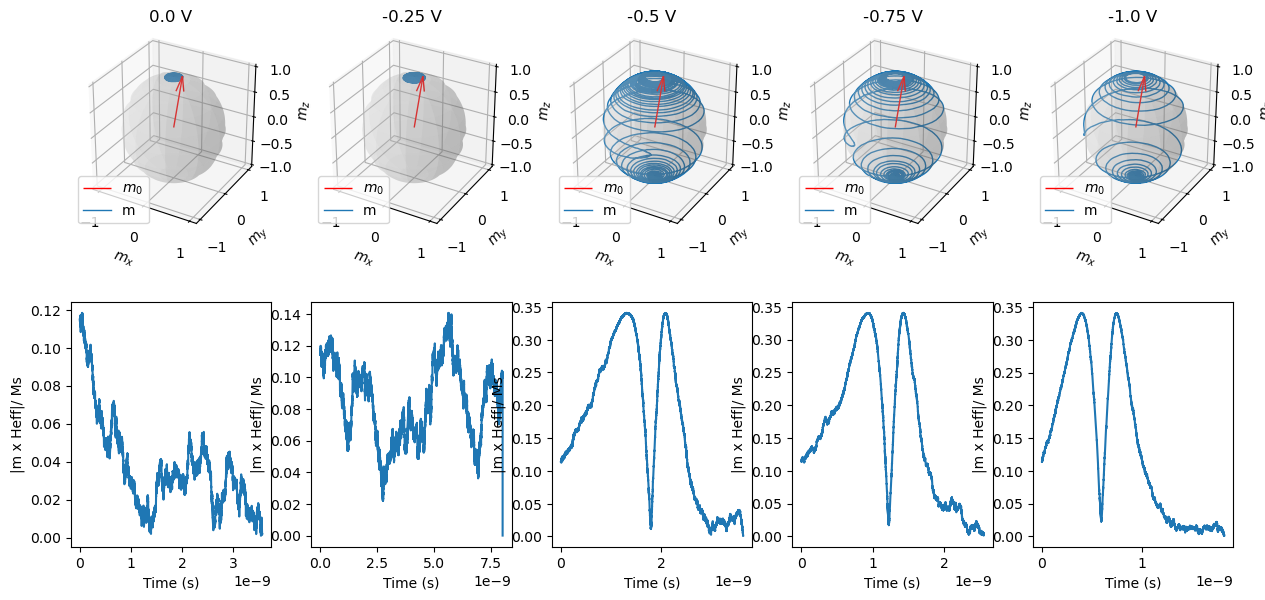

In [21]:
fig = plt.figure(figsize=(15, 7))
V = np.linspace(0, -1, 5)
for i, V_i in enumerate(V):
    m, torque, time_series, energy = calculate_magnetization(voltage=V_i)

    sphere_ax = fig.add_subplot(2, len(V), i + 1, projection="3d")
    plot_unit_sphere(sphere_ax, m, "m", f"{V_i} V")

    ax = fig.add_subplot(2, len(V), len(V) + 1 + i)
    ax.plot(time_series, torque)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("|m x Heff|/ Ms")

With initial magnetization in negative z-direction, a positive voltage has to be applied to have switching.

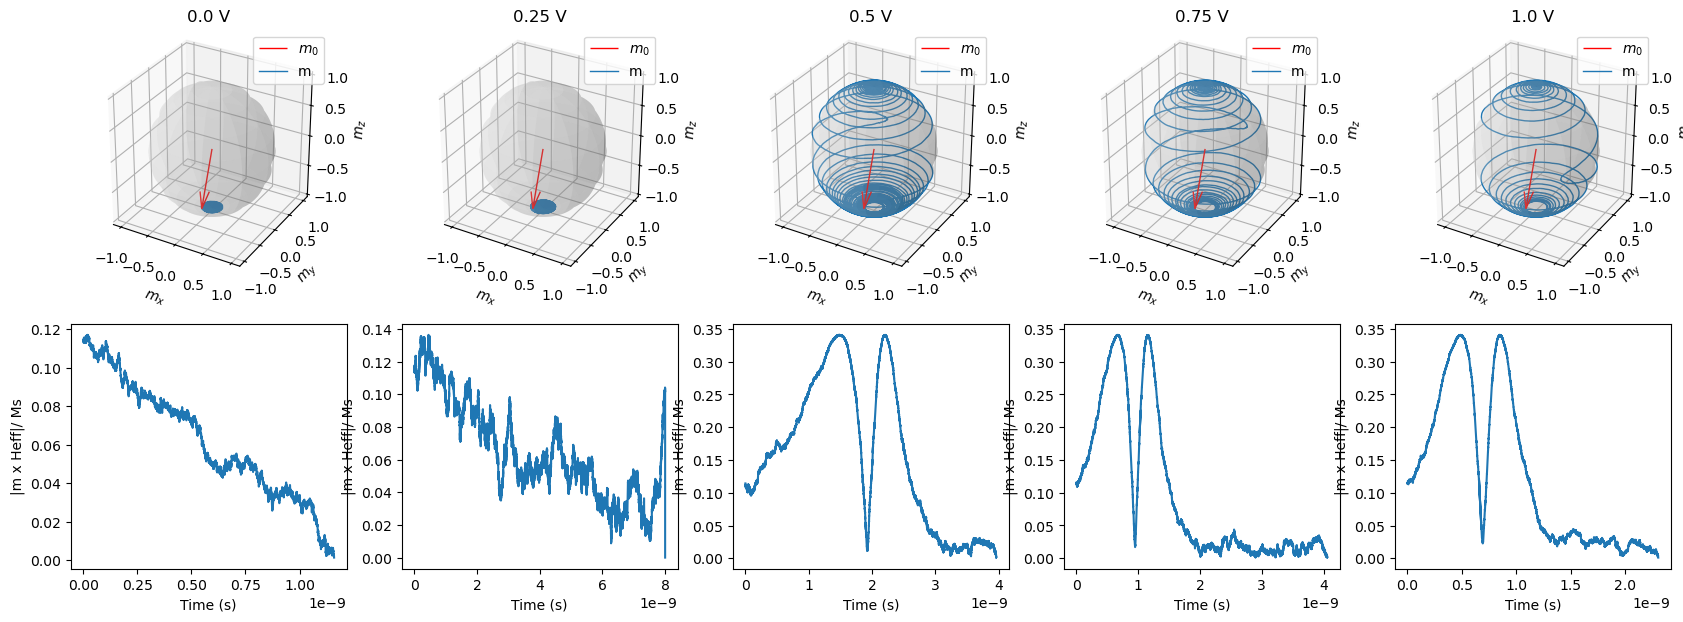

In [22]:
fig = plt.figure(figsize=(16, 7))
V = np.linspace(0, 1, 5)
for i, V_i in enumerate(V):
    m, torque, time_series, energy = calculate_magnetization(m0=-m0, voltage=V_i)

    sphere_ax = fig.add_subplot(2, len(V), i + 1, projection="3d")
    plot_unit_sphere(sphere_ax, m, "m", f"{V_i} V")

    ax = fig.add_subplot(2, len(V), len(V) + 1 + i)
    ax.plot(time_series, torque)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("|m x Heff|/ Ms")

fig.subplots_adjust(right=1, left=0)

We can combine these results in one figure:

In [23]:
num_samples = 3

rng = np.random.default_rng()
voltages = np.linspace(-1, 1, num_samples)

out = []

for V_i in voltages:
    m_init = m0
    if V_i > 0:
        m_init = -m0

    m, torque, time, energy = calculate_magnetization(m0=m_init, voltage=V_i)

    out.append([V_i, m, torque, time, energy])

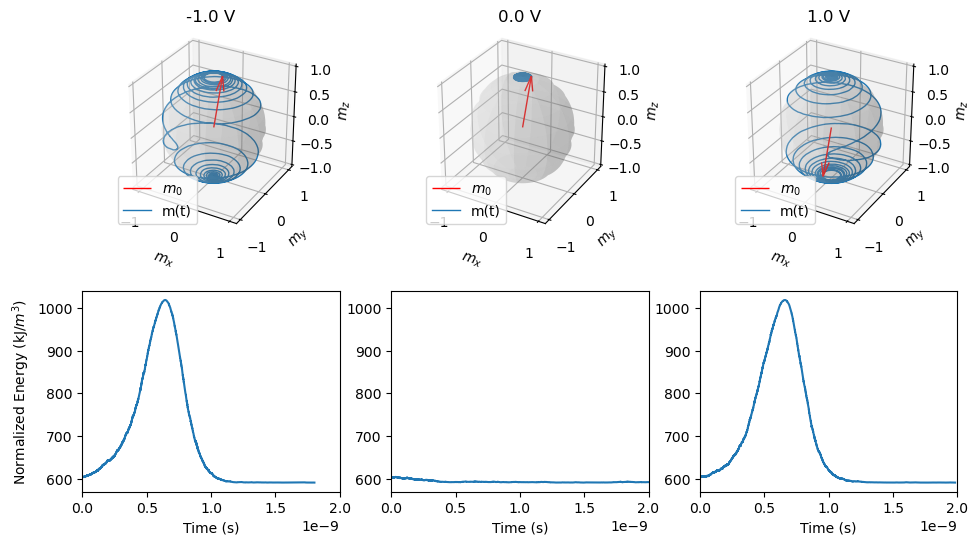

In [25]:
ax = []
fig = plt.figure(figsize=(10, 6))
for i, (V_i, m, torque, time_series, energy) in enumerate(out):
    sphere_ax = fig.add_subplot(2, len(out), i + 1, projection="3d")
    plot_unit_sphere(sphere_ax, m, "m(t)", f"{V_i} V")

    ax.append(fig.add_subplot(2, len(out), len(out) + 1 + i))
    ax[i].plot(time_series, energy/1000)
    ax[i].sharey(ax[0])
    ax[i].set_xlabel("Time (s)")
    ax[i].set_xlim(0, 2e-9)
ax[0].set_ylabel("Normalized Energy (kJ/$m^3$)")
fig.subplots_adjust(right=1, wspace=0.2, hspace=0.3)